# <font color='#1a5276'> <b> <center> Dropout </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Example 1](#3) <br>
    3.1. [Data](#3.1) <br>
    3.2. [Model architecture and training](#3.2) <br>
    3.3. [Model comparisson](#3.3) <br>
4. [Example 2](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model architecture, training and evaluation](#4.3) <br>
5. [Annex](#annex)
6. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of the input units to zero during training. This encourages the network to learn robust features and improves generalization.

This notebook demonstrates the concept of dropout in neural networks through two examples.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [3]:
# seed
torch.manual_seed(0) 

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1</b> </font>

<a name="3.1"></a>
### <font color='#2471a3'> <b> 3.1. Helper Functions</b> </font>

In [4]:
# plot decision regions
def plot_decision_regions_3class(data_set, model=None):
    """
    Plots the decision regions for a 3-class classification problem and overlays the true decision boundary.

    Parameters:
    - data_set: An object containing the dataset, expected to have `x`, `y`, and `multi_dim_poly` attributes.
                `x` and `y` are assumed to be numpy-like arrays for features and labels.
                `multi_dim_poly` is a function that computes the decision boundary.
    - model: (Optional) A PyTorch model. If provided, the model's predictions are used to generate the decision regions.

    Returns:
    - None: Displays the plot of decision regions and the true decision boundary.
    """
    # Define color maps for plotting the regions and boundaries
    cmap_light = ListedColormap(['#0000FF', '#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    
    # Extract feature and label data from the dataset
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    
    # Define the resolution for the mesh grid
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    
    # Create a mesh grid over the feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute the true decision boundary using the dataset's polynomial function
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    
    if model != None:
        # If a model is provided, evaluate its predictions
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        
        # Plot the model's decision regions
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        # Overlay the true decision boundary
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        # Plot only the true decision boundary
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light)

    # Add a title to the plot
    plt.title("decision region vs True decision boundary")

    
# calculate accuracy
def accuracy(model, dataset):
    _, yhat = torch.max(model(dataset.x), 1)
    return (yhat == dataset.y).numpy().mean()

<a name="3.2"></a>
### <font color='#2471a3'> <b> 3.2. Data </b> </font>

We will create a non-linearly separable dataset.

In [5]:
# Create data class for creating dataset object
class Data(Dataset):
    """
    A custom dataset class for generating synthetic data for binary classification tasks.
    This dataset includes features, labels, and noise for training and testing purposes.

    Attributes:
    - x: Features of the dataset (torch.FloatTensor).
    - y: Labels of the dataset (torch.LongTensor).
    - f: True decision function values (torch.FloatTensor).
    - a: Coefficients used for generating the data (numpy matrix).

    Methods:
    - __getitem__(index): Retrieves a single sample (feature, label) by index.
    - __len__(): Returns the total number of samples in the dataset.
    - plot(): Plots the data points and the true decision boundary.
    - multi_dim_poly(x): Computes the polynomial decision boundary for given input `x`.
    """

    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        """
        Initializes the dataset with a specified number of samples, noise level, and training flag.

        Parameters:
        - N_SAMPLES: Number of samples to generate (default: 1000).
        - noise_std: Standard deviation of noise to add to the features (default: 0.15).
        - train: Boolean indicating if the dataset is for training (default: True).
        """
        # Define coefficients for the polynomial function
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        
        # Generate random feature data
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        
        # Compute the true decision function
        self.f = np.array(
            a[0] + (self.x) * a[1:3] + 
            np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + 
            np.multiply(self.x, self.x) * a[5:7]
        ).flatten()
        self.a = a
        
        # Generate labels based on the decision function
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        
        # Convert features to PyTorch tensors and add noise
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        
        if train:
            # Add additional noise for training datasets
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
    
    # Getter
    def __getitem__(self, index):    
        """
        Retrieves the feature and label at a given index.

        Parameters:
        - index: The index of the sample to retrieve.

        Returns:
        - A tuple (feature, label).
        """
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        - Length of the dataset.
        """
        return self.len
    
    # Plot the diagram
    def plot(self):
        """
        Plots the data points with noise and overlays the true decision boundary.
        """
        X = self.x.numpy()
        y = self.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary and sample points with noise')
        plt.scatter(self.x[y == 0, 0].numpy(), self.x[y == 0, 1].numpy(), c='blue', label='y=0', edgecolors='k') 
        plt.scatter(self.x[y == 1, 0].numpy(), self.x[y == 1, 1].numpy(), c='red', label='y=1', edgecolors='k')
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend()
        
        
    # Make a multidimension polynomial function
    def multi_dim_poly(self, x):
        """
        Computes the polynomial decision boundary for the given input.

        Parameters:
        - x: Input data (numpy array or matrix).

        Returns:
        - The computed decision boundary values.
        """
        x = np.matrix(x)
        out = np.array(
            self.a[0] + (x) * self.a[1:3] + 
            np.multiply(x[:, 0], x[:, 1]) * self.a[4] + 
            np.multiply(x, x) * self.a[5:7]
        )
        return np.array(out)


In [6]:
# dataset for training
train_dataset = Data(noise_std = 0.2)

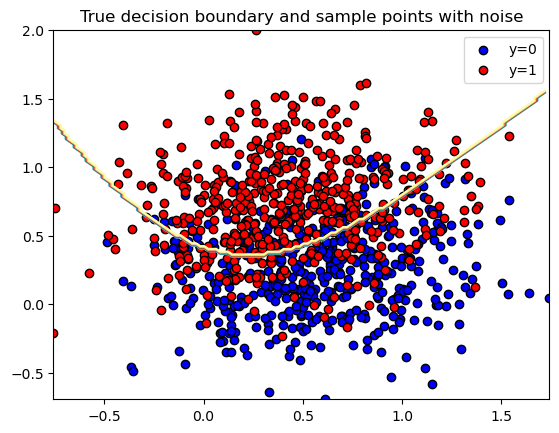

In [7]:
# plot
train_dataset.plot()

In [8]:
# validation data
val_dataset = Data(train=False)

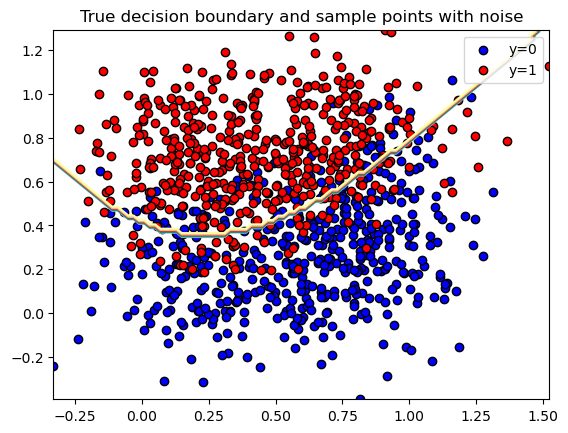

In [9]:
# plot
val_dataset.plot()

<a name="3.3"></a>
### <font color='#2471a3'> <b> 3.3. Model and training </b> </font>

### Results

In [10]:
# To store results
loss = {}
loss['training data no dropout'] = []
loss['validation data no dropout'] = []
loss['training data dropout'] = []
loss['validation data dropout'] = []

### Model definition

In [16]:
class Net(nn.Module):
    """
    A neural network model with dropout.

    Attributes:
    - linear1 (nn.Linear): First fully connected layer.
    - linear2 (nn.Linear): Second fully connected layer.
    - linear3 (nn.Linear): Third fully connected layer (output layer).
    - drop (nn.Dropout): Dropout layer for regularization.

    Methods:
    - forward(x): Defines the forward pass of the network, applying layers in sequence with activation and dropout.
    """

    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        """
        Initializes the network with input size, hidden layer size, output size, and dropout probability.

        Parameters:
        - in_size (int): Number of input features.
        - n_hidden (int): Number of neurons in the hidden layers.
        - out_size (int): Number of output features.
        - p (float): Dropout probability (default: 0, no dropout).
        """
        super(Net, self).__init__()
        
        # Dropout layer for regularization
        self.drop = nn.Dropout(p=p)
        
        # Fully connected layers
        self.linear1 = nn.Linear(in_size, n_hidden)  # Input to first hidden layer
        self.linear2 = nn.Linear(n_hidden, n_hidden)  # First hidden layer to second hidden layer
        self.linear3 = nn.Linear(n_hidden, out_size)  # Second hidden layer to output layer

    # Forward pass
    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, in_size).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, out_size).
        """
        # Apply first linear layer, dropout, and ReLU activation
        x = F.relu(self.drop(self.linear1(x)))
        
        # Apply second linear layer, dropout, and ReLU activation
        x = F.relu(self.drop(self.linear2(x)))
        
        # Apply third linear layer (output layer)
        x = self.linear3(x)
                
        return x


During the training of a neural network model, dropout is a regularization technique where neurons in a layer are randomly "dropped out" (i.e., set to zero) with a probability 
𝑝
p. This means their contribution to the activation of downstream neurons is temporarily removed during the forward pass, and no weight updates are applied to them during the backward pass.

When the model is used for inference, dropout is turned off, and the outputs of the neurons are scaled by 
(1−p) during training to ensure consistency between training and inference.

Dropout may seem counterintuitive, as it effectively reduces the model's capacity during training. However, it can improve the model's accuracy by reducing overfitting. Without dropout, neurons may develop complex co-adaptations where they overly rely on specific combinations of other neurons. This can make the model fragile and overly specialized to the training data.

By randomly dropping neurons during training, dropout forces the network to develop multiple independent representations of the data. This reduces the sensitivity to specific weights and helps the network generalize better, ultimately improving performance on unseen data.

model.eval() ensures that dropout is disabled during inference and the full network is used as is. 

Training Mode (model.train()):
Dropout is active.
During the forward pass, neurons are randomly dropped out (set to zero) with a probability 
𝑝
p.
The remaining active neurons are not scaled during training because the scaling effect is handled automatically by PyTorch's Dropout implementation when it's turned off during inference.
Evaluation Mode (model.eval()):
Dropout is turned off.
All neurons are active, and no randomness is introduced.
PyTorch automatically adjusts for the effect of dropout by ensuring that the weights and activations trained with dropout are directly used without any additional scaling.
This means that the scaling to account for dropout during training is built into PyTorch's dropout layer itself. You don't need to explicitly handle any scaling when switching between training and evaluation modes.

Key Points:
In Training: Dropout randomly zeroes out neurons, and no explicit scaling occurs during this phase.
In Evaluation: Dropout is disabled, and PyTorch internally ensures that the behavior of the network is consistent with the trained weights.
This mechanism is why you should always use model.eval() when performing inference to ensure that dropout (and other layers like BatchNorm) behave correctly for evaluation.

In [13]:
type(train_dataset.x)

torch.Tensor

### Optimizers and criterion

In [ ]:
# set the optimizers

# model without dropout
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)

# model with dropout
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)

In [15]:
# criterion
criterion = torch.nn.CrossEntropyLoss() # we do not usa a softmax

We will create 2 model, one without dropout and the other with a dropout of 0.5:

In [88]:
# model without dropout
model = Net(2, 300, 2)

# model with dropout
model_drop = Net(2, 300, 2, p=0.5)

### Training function

In [89]:
aux = list(model.parameters())

In [90]:
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, epochs=300, lr=0.01, batch_size=5):
    
    # Training DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation DataLoader (no shuffling)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=len(X_val), shuffle=False)
    
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # train
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)            
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # evaluate after training
    model.eval()  # Set model to evaluation mode
    total_accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            preds = torch.argmax(outputs, dim=1)
            accuracy = (preds == y_val).float().mean().item()
            total_accuracy += accuracy * len(y_val)
            total_samples += len(y_val)

    accuracy = total_accuracy / total_samples
    return model, accuracy



In [91]:
train_model_1, acc_model_1 = train_model(
    model,
    train_dataset.x,
    train_dataset.y,
    val_dataset.x,
    val_dataset.y,
    criterion,
    epochs=10,
) 

In [92]:
acc_model_1

0.8339999914169312

In [93]:
aux2 = list(model.parameters())

In [94]:
aux == aux2

True

In [54]:
train_model_2, acc_model_2 = train_model(
    model_drop,
    train_dataset.x,
    train_dataset.y,
    val_dataset.x,
    val_dataset.y,
    criterion,
    epochs=10,
) 

In [55]:
acc_model_2

0.824999988079071

Cross Entropy Loss

In [62]:
 # Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()



In [63]:
input

tensor([[-0.2066,  0.6509, -0.1362,  1.0075,  0.3165],
        [-1.8017,  0.5474,  1.8853,  1.2998,  2.6157],
        [-0.0823, -0.0856, -1.7035,  0.3242, -0.5383]], requires_grad=True)

In [64]:
target

tensor([0, 3, 3])

In [67]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [68]:
input

tensor([[-0.2562,  0.8594, -0.9452,  0.1453,  0.1360],
        [ 0.0523, -0.0106,  1.0208, -0.1421,  1.7995],
        [-1.2666,  0.1328, -0.0622, -0.7571, -0.3754]], requires_grad=True)

In [69]:
target

tensor([[0.0498, 0.2764, 0.0256, 0.5161, 0.1321],
        [0.1400, 0.1358, 0.1565, 0.1881, 0.3796],
        [0.1437, 0.0431, 0.1100, 0.4955, 0.2077]])

In [70]:
output

tensor(1.6680, grad_fn=<DivBackward1>)

In [80]:
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, epochs=300, lr=0.01, batch_size=5):
    
    # Training DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation DataLoader (no shuffling)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #batch_size=len(X_val)
    
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # To store the losses per epoch
    train_losses = []
    val_losses = []
    
    # train
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)            
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # evaluate after training (validation loss)
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        total_accuracy = 0
        total_samples = 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                loss = loss_fn(outputs, y_val)  # Compute validation loss
                total_val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                accuracy = (preds == y_val).float().mean().item()
                total_accuracy += accuracy * len(y_val)
                total_samples += len(y_val)

        # Average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute validation accuracy
        accuracy = total_accuracy / total_samples
        
        # Print the loss and accuracy for the epoch
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return model, accuracy, train_losses, val_losses


In [81]:
train_model_1, acc_model_1, train_losses, val_losses = train_model(
    model,
    train_dataset.x,
    train_dataset.y,
    val_dataset.x,
    val_dataset.y,
    criterion,
    epochs=10,
) 

Epoch [1/10], Train Loss: 0.4947, Validation Loss: 0.4303, Validation Accuracy: 0.8070
Epoch [2/10], Train Loss: 0.4691, Validation Loss: 0.3808, Validation Accuracy: 0.8150
Epoch [3/10], Train Loss: 0.4663, Validation Loss: 0.4233, Validation Accuracy: 0.8100
Epoch [4/10], Train Loss: 0.4643, Validation Loss: 0.4197, Validation Accuracy: 0.8020
Epoch [5/10], Train Loss: 0.4722, Validation Loss: 0.3987, Validation Accuracy: 0.7970
Epoch [6/10], Train Loss: 0.4634, Validation Loss: 0.4045, Validation Accuracy: 0.8040
Epoch [7/10], Train Loss: 0.4644, Validation Loss: 0.3900, Validation Accuracy: 0.8150
Epoch [8/10], Train Loss: 0.4660, Validation Loss: 0.4065, Validation Accuracy: 0.8000
Epoch [9/10], Train Loss: 0.4645, Validation Loss: 0.4130, Validation Accuracy: 0.8050
Epoch [10/10], Train Loss: 0.4635, Validation Loss: 0.4050, Validation Accuracy: 0.7960


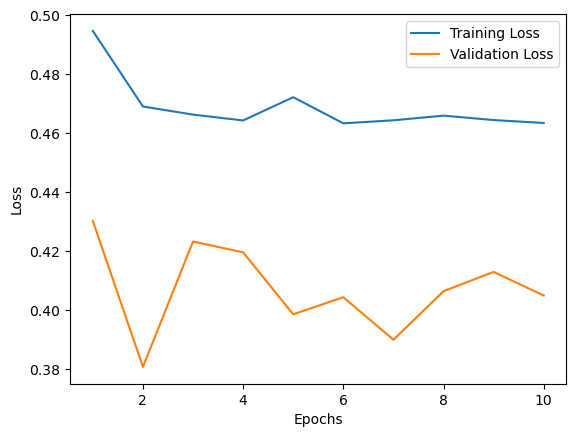

In [82]:
# Plot the losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
train_model_2, acc_model_2, train_losses_2, val_losses_2 = train_model(
    model_drop,
    train_dataset.x,
    train_dataset.y,
    val_dataset.x,
    val_dataset.y,
    criterion,
    epochs=10,
) 

Epoch [1/10], Train Loss: 0.5824, Validation Loss: 0.3777, Validation Accuracy: 0.8300
Epoch [2/10], Train Loss: 0.5826, Validation Loss: 0.4359, Validation Accuracy: 0.8270
Epoch [3/10], Train Loss: 0.5648, Validation Loss: 0.4222, Validation Accuracy: 0.8200
Epoch [4/10], Train Loss: 0.5711, Validation Loss: 0.4395, Validation Accuracy: 0.8270
Epoch [5/10], Train Loss: 0.5579, Validation Loss: 0.4389, Validation Accuracy: 0.8170
Epoch [6/10], Train Loss: 0.5496, Validation Loss: 0.4368, Validation Accuracy: 0.8190
Epoch [7/10], Train Loss: 0.5732, Validation Loss: 0.4763, Validation Accuracy: 0.8270
Epoch [8/10], Train Loss: 0.5592, Validation Loss: 0.5306, Validation Accuracy: 0.7680
Epoch [9/10], Train Loss: 0.5399, Validation Loss: 0.4637, Validation Accuracy: 0.8090
Epoch [10/10], Train Loss: 0.5311, Validation Loss: 0.4780, Validation Accuracy: 0.8300


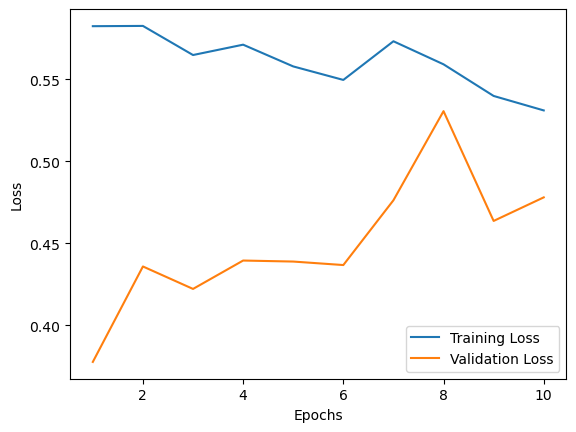

In [84]:
# Plot the losses
plt.plot(range(1, len(train_losses_2) + 1), train_losses_2, label='Training Loss')
plt.plot(range(1, len(val_losses_2) + 1), val_losses_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

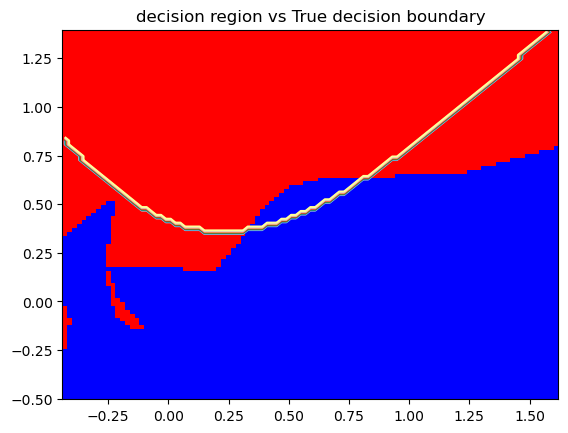

In [86]:
plot_decision_regions_3class(val_dataset, train_model_1)

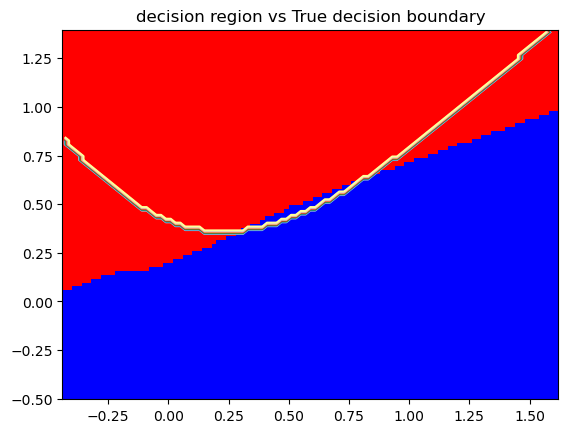

In [87]:
plot_decision_regions_3class(val_dataset, train_model_2)